# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [3]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

#%matplotlib inline

#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Чокля".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin
from tqdm import tqdm

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.error = np.ones(max_epoch) * (-1)
        self.weights = np.array([])
    
    def _sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def fit(self, X, y):
        '''
        Обучение модели
        '''

        X_expanded = np.hstack((np.array([[1] for i in xrange(X.shape[0])]), X))
        self.weights = np.zeros(X_expanded.shape[1], dtype=float)
        
        for i in tqdm(xrange(self.max_epoch)):        
            indexes = np.random.permutation(X.shape[0])

            for j in indexes:
                s = self._sigmoid(self.weights.dot(X_expanded[j]))
                self.weights = self.weights + self.alpha * (y[j] - s) * X_expanded[j] - (self.alpha / self.C) * np.sign(self.weights) 
                self.alpha *= (1.0 - self.alpha / self.max_epoch)
                
            y_hat = X_expanded.dot(self.weights)
            err = sum(np.log(self._sigmoid(y * y_hat))) * np.exp(-1 * sum(abs(self.weights)) / self.C)
            
            self.error[i] = -err
            # uncomment for real tasks
            #if i > 0 and abs(self.error[i] - self.error[i - 1]) < 0.000001:
            #    break
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        return X.dot(self.weights[1:]) + self.weights[0] > 0
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''  
        return self._sigmoid(X.dot(self.weights[1:]) + self.weights[0])

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [540]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

In [553]:
model = MySGDClassifier(alpha=0.005, max_epoch=100, C=100000)
model.fit(X, y)

MySGDClassifier(C=100000, alpha=0.00166663614925, max_epoch=100)

In [554]:
model.weights

array([-4.49345697,  1.00305493, -1.07595309])

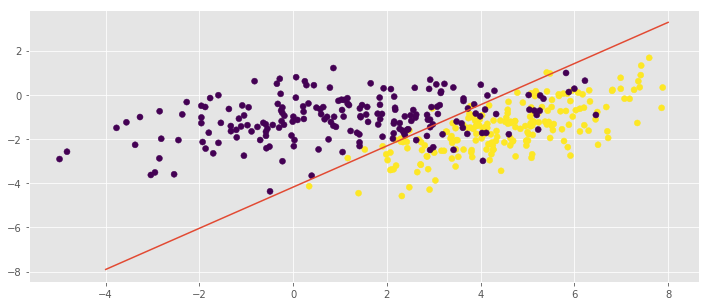

In [555]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot([-4, 8], [(4 * model.weights[1] - model.weights[0]) / model.weights[2], 
                  (-8 * model.weights[1] - model.weights[0]) / model.weights[2]])

Любопытства ради...

In [556]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y, model.predict_proba(X))

0.94717499999999999

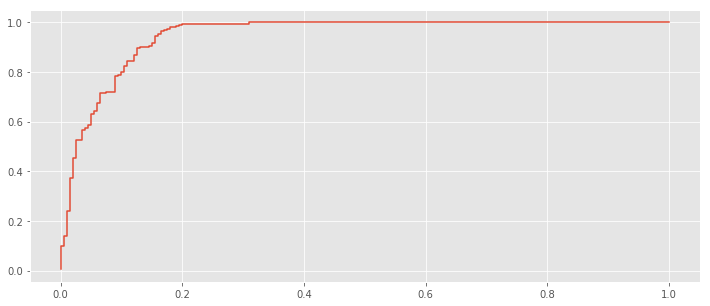

In [557]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y, model.predict_proba(X))
plt.plot(fpr, tpr)

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

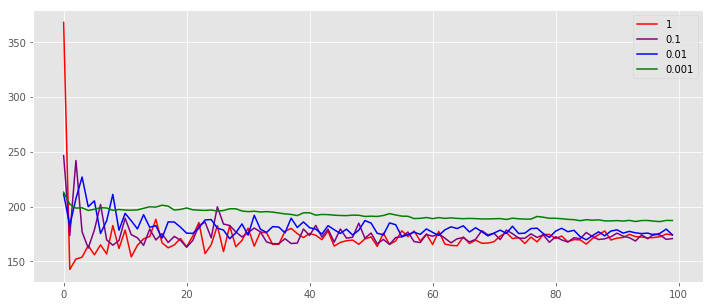

In [589]:
alphas = [1, 0.1, 0.01, 0.001]
colors = ['red', 'purple', 'blue', 'green']

for i in range(len(alphas)):
    m = MySGDClassifier(alpha=alphas[i], max_epoch=100, C = 100)
    m.fit(X, y)
    plt.plot(m.error, color=colors[i], label=str(alphas[i]))
plt.legend()

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [4]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './heartstone/trainingData_tabular/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [14]:
df_data.shape

(500000, 45)

In [5]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [11]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [12]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50470199999999998

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [13]:
sorted(df_data['player_hero_card_id'].unique())

[25, 326, 390, 494, 612, 754, 798, 981, 1235]

In [14]:
sorted(df_data['opponent_hero_card_id'].unique())

[25, 326, 390, 494, 612, 754, 798, 981, 1235]

In [6]:
df_data = pd.get_dummies(data=df_data, columns=['player_hero_card_id', 'opponent_hero_card_id'])
df_data = df_data.drop(['player_hero_card_id_1235', 'opponent_hero_card_id_1235'], axis=1)

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [7]:
X = df_data.drop('decision', axis=1)
y = df_data['decision']

In [32]:
clf = MySGDClassifier(C = 2000, alpha=0.1, max_epoch=50)

In [33]:
clf.fit(X.values, y.values)

100%|██████████| 50/50 [07:32<00:00,  8.72s/it]


MySGDClassifier(C=2000, alpha=1.99995913517e-06, max_epoch=50)

In [34]:
clf.weights

array([ -2.85079412e-05,   5.01685366e-02,  -2.68249794e-03,
        -1.27439878e-02,  -8.20826752e-02,   1.88093393e-01,
         3.26806255e-05,   1.23988652e-02,   1.87979292e-02,
        -2.76025498e-02,   1.20562253e-01,  -1.70282508e-01,
         2.77856926e-02,   1.35868033e-03,   3.83254171e-02,
         8.26829318e-02,  -1.09194570e-01,   4.21373358e-03,
        -1.26661482e-01,   2.91252924e-02,   3.46388186e-02,
        -8.74709155e-03,   4.78270265e-03,  -4.68542515e-02,
         2.77856926e-02,  -8.64343049e-02,   3.38328669e-05,
        -6.22871331e-02,  -1.29856863e-02,  -4.68542515e-02,
         8.42775003e-02,   1.24585563e-02,   4.36835232e-02,
         3.22903507e-02,   6.09944800e-02,   1.50330611e-02,
        -1.44668958e-01,   4.78270265e-03,   6.95644083e-03,
         1.45004819e-02,   6.10506325e-03,   1.87346557e-02,
        -2.15214913e-01,   1.14871743e-01,  -5.72524362e-05,
         5.49108040e-05,   1.39144220e-07,   1.15839618e-01,
         1.66362532e-01,

In [35]:
res = clf.predict_proba(X)

In [18]:
from sklearn.metrics import roc_auc_score

In [36]:
roc_auc_score(y, res)

0.78553250484873527

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [67]:
test = pd.read_csv('./heartstone/testData_tabular.csv', sep=',')

In [68]:
test.columns = test.columns.str.replace('.', '_')
test = test.set_index('gamestate_id')
test = pd.get_dummies(data=test, columns=['player_hero_card_id', 'opponent_hero_card_id'])
test = test.drop(['player_hero_card_id_1235', 'opponent_hero_card_id_1235', 'decision'], axis=1)

In [72]:
np.savetxt('test_res.txt', clf.predict_proba(test), fmt='%2.12f')

In [74]:
print 'dimjava', ':', '0.7874'

dimjava : 0.7874
